# Digit Classification

### The problem:

*Given a large dataset of images of handwritten digits, the goal is to design an algorithm that can identify the number written given a new image of a handwritten digit.*

### The solution:

PCA was used to reduce the dimensionality of a dataset of images of handwritten digits from the MNIST database. The dataset was then used to train four different classifiers: Ridge regression classification, K-Nearest Neighbors, Linear Discriminant Analysis, and Support Vector Machines. Each classifier was tested and compared on their ability to determine the digit written in a given image sample from both the training and testing datasets. Of the four models, K-Nearest neighbors had the best combination of both cross validated accuracy and efficiency.


In [1]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import time
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Load Data
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)
        
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

(784, 60000)
(60000,)
(784, 10000)
(10000,)


In [2]:
# Perform PCA on training set

pca = PCA()
pca.fit(Xtraindata.T)
print(pca.components_.shape)

(784, 784)


Text(0, 0.5, 'Cumulative Energy')

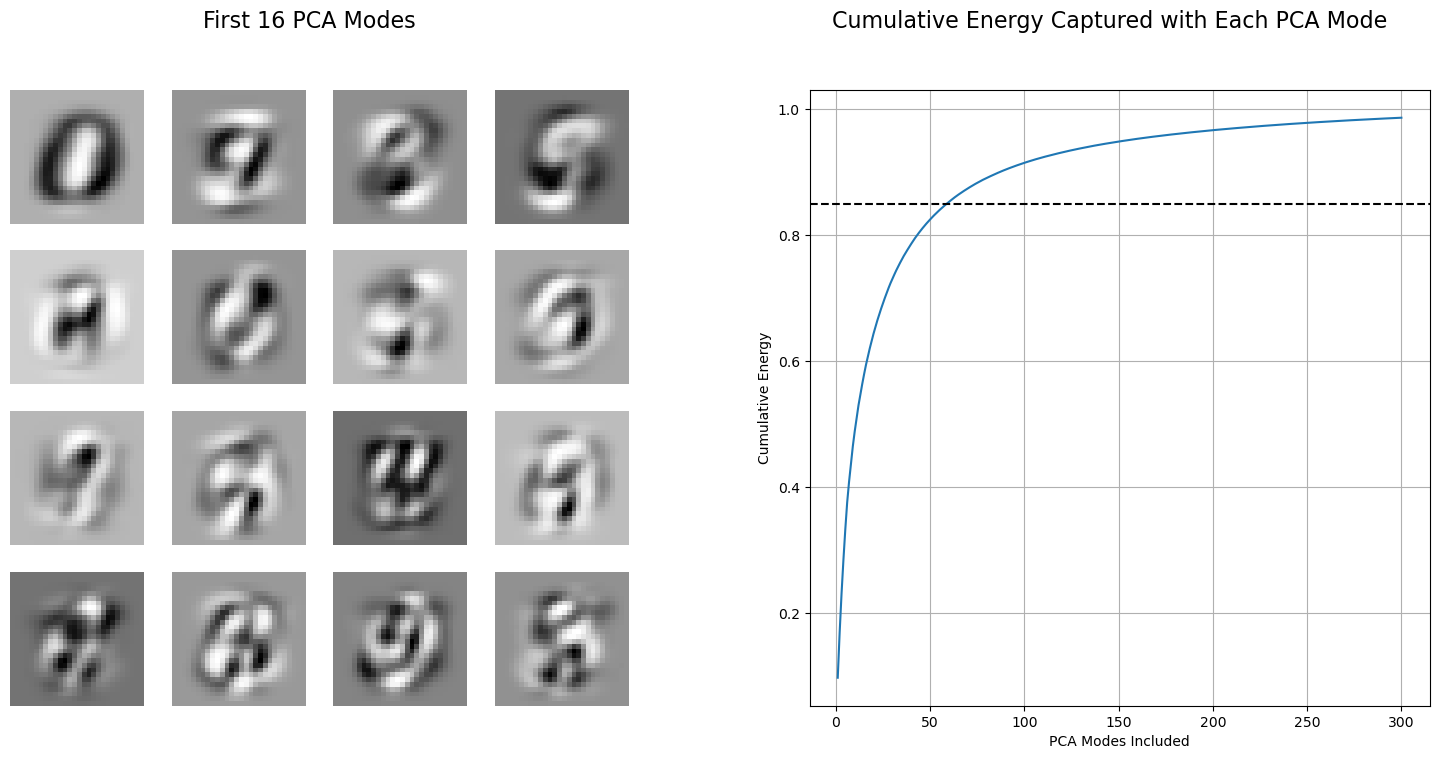

In [3]:
fig = plt.figure(figsize=(16, 8))
subfigs = fig.subfigures(1, 2)

# Plot the first 16 PCA modes
pca16 = pca.components_[:16]

N = 4
ax = subfigs[0].subplots(N, N)
for i in range(N):
    for j in range(N):
        ax[i,j].imshow(pca16[N*i+j,:].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
subfigs[0].suptitle("First 16 PCA Modes", size=16)

# Plot the cumulative energy captured with each PCA mode

stop = 300
svs = pca.singular_values_
cum_e = np.cumsum(np.power(svs,2)/np.sum(np.power(svs,2)))
frame = subfigs[1].subplots(1, 1)
frame.plot(np.arange(1, stop + 1, 1), cum_e[:stop])
frame.axhline(y=0.85, color="k", linestyle="--")
frame.grid(True)
subfigs[1].suptitle("Cumulative Energy Captured with Each PCA Mode", size=16)
frame.set_xlabel('PCA Modes Included')
frame.set_ylabel('Cumulative Energy')


In [4]:
# Find number of modes needed to capture 85% of the energy

k85 = next(i for i, v in enumerate(cum_e) if v > 0.85) + 1
print("Modes needed to to capture 85%: {}".format(k85))

Modes needed to to capture 85%: 59


In [5]:
# Reconstruct digit image approximations from truncated data

pcak85 = PCA(n_components=k85)
pcak85.fit(Xtraindata.T)
xtraintrunc = pcak85.transform(Xtraindata.T)
reconstruction = pcak85.inverse_transform(xtraintrunc)
print(reconstruction.shape)


(60000, 784)


Text(0.5, 0.98, '59 Mode Approximated Images')

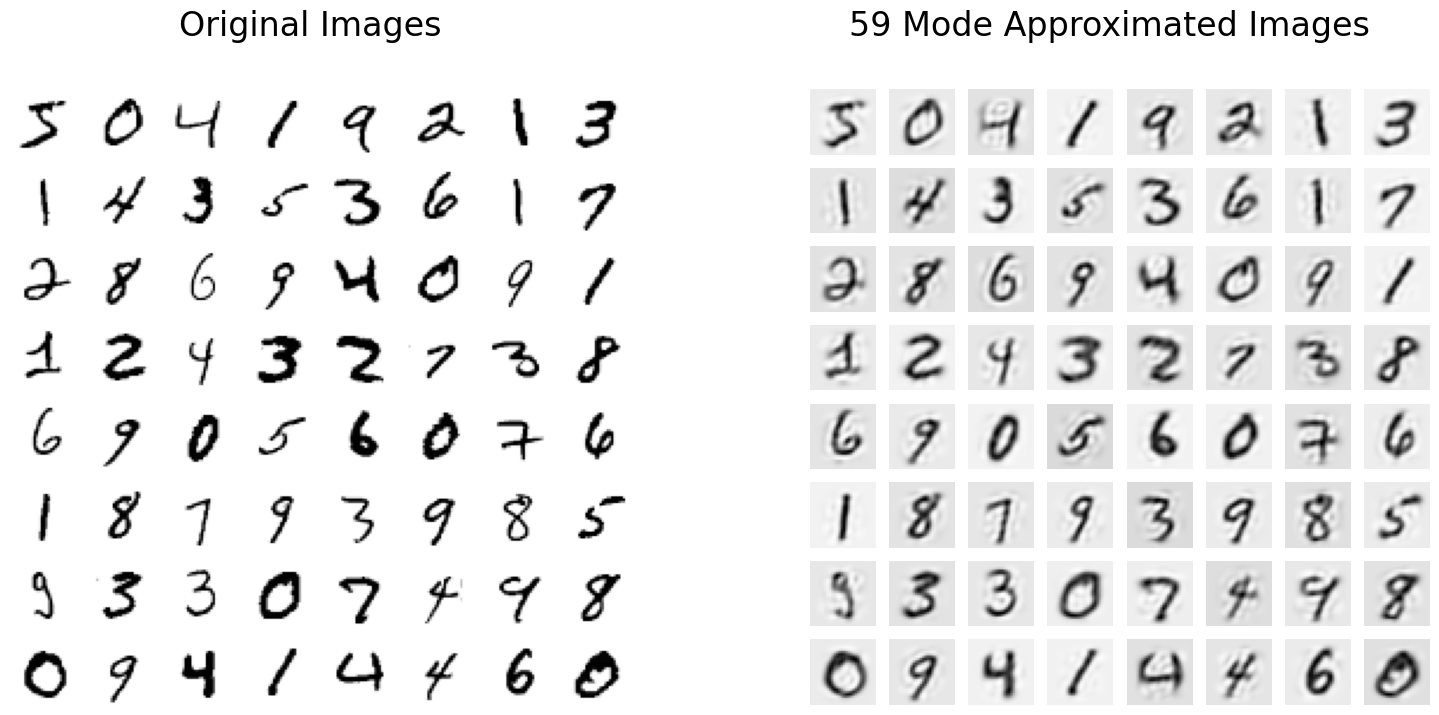

In [6]:
# Compare Approximated Training Images to Original Images

fig = plt.figure(figsize=(16, 8))
subfigs = fig.subfigures(1, 2)

# Original
axs = subfigs[0].subplots(8, 8)
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(Xtraindata[:, (8)*i+j].reshape((28, 28)), cmap="Greys")
        axs[i,j].axis("off")

subfigs[0].suptitle("Original Images", fontsize=24)

# Approximated
axs = subfigs[1].subplots(8, 8)
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(reconstruction[(8)*i+j, :].reshape((28, 28)), cmap="Greys")
        axs[i,j].axis("off")

subfigs[1].suptitle("59 Mode Approximated Images", fontsize=24)


In [7]:
ids = ytrainlabels == 1
print(ids)

[False False False ... False False False]


In [8]:
# Function for finding images of a single digit

def digit_subset(digit):
    train_ids = ytrainlabels == digit
    test_ids = ytestlabels == digit
    return [Xtraindata[:, train_ids], 
            ytrainlabels[train_ids], 
            Xtestdata[:, test_ids],
            ytestlabels[test_ids]]

In [9]:
# Combines image subsets of two digits and randomly shuffles them

def two_digit_shuffle(d1, d2):
    a = digit_subset(d1)
    b = digit_subset(d2)
    tr_shuffle_ids = np.random.permutation(np.hstack((a[0], b[0])).shape[1])
    x_train_ab = np.hstack((a[0], b[0]))[:, tr_shuffle_ids]
    y_train_ab = np.hstack((a[1], b[1]))[tr_shuffle_ids]
    te_shuffle_ids = np.random.permutation(np.hstack((a[2], b[2])).shape[1])
    x_test_ab = np.hstack((a[2], b[2]))[:, te_shuffle_ids]
    y_test_ab = np.hstack((a[3], b[3]))[te_shuffle_ids]
    return [x_train_ab, y_train_ab, x_test_ab, y_test_ab]

In [10]:
sub_cross_scores = []
sub_cross_stds = []
sub_tr_scores = []
sub_te_scores = []

In [11]:
# Subset of digits 1 and 8
subset_18 = two_digit_shuffle(1, 8)
xtr18_proj = pcak85.components_ @ subset_18[0]

In [12]:
# Train ridge classifier on subset projection
ridge18 = RidgeClassifierCV()
ridge18.fit(xtr18_proj.T, subset_18[1])

RidgeClassifierCV()

In [13]:
# Score of training and testing data sets
print("Training Score: {}".format(ridge18.score(xtr18_proj.T, subset_18[1])))
xte18_proj = pcak85.components_ @ subset_18[2]
print("Testing Score: {}".format(ridge18.score(xte18_proj.T, subset_18[3])))
sub_tr_scores.append(ridge18.score(xtr18_proj.T, subset_18[1]))
sub_te_scores.append(ridge18.score(xte18_proj.T, subset_18[3]))

Training Score: 0.9662510918764393
Testing Score: 0.9800853485064012


In [14]:
# Cross Validation
scores = cross_val_score(ridge18, xtr18_proj.T, subset_18[1], cv=5)
sub_cross_scores.append(scores.mean())
sub_cross_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.9652188403873216 accuracy with a standard deviation of 0.0016373820198980048


In [15]:
# Subset of digits 3 and 8
subset_38 = two_digit_shuffle(3, 8)
xtr38_proj = pcak85.components_ @ subset_38[0]

In [16]:
# Train ridge classifier
ridge38 = RidgeClassifierCV()
ridge38.fit(xtr38_proj.T, subset_38[1])

RidgeClassifierCV()

In [17]:
# Score of training and testing data sets
print("Training Score: {}".format(ridge38.score(xtr38_proj.T, subset_38[1])))
xte38_proj = pcak85.components_ @ subset_38[2]
print("Testing Score: {}".format(ridge38.score(xte38_proj.T, subset_38[3])))
sub_tr_scores.append(ridge38.score(xtr38_proj.T, subset_38[1]))
sub_te_scores.append(ridge38.score(xte38_proj.T, subset_38[3]))

Training Score: 0.9604406609914873
Testing Score: 0.9637096774193549


In [18]:
# Cross Validation
scores = cross_val_score(ridge38, xtr38_proj.T, subset_38[1], cv=5)
sub_cross_scores.append(scores.mean())
sub_cross_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.9591053577684404 accuracy with a standard deviation of 0.0009500729846326175


In [19]:
# Subset of digits 2 and 7
subset_27 = two_digit_shuffle(2, 7)
xtr27_proj = pcak85.components_ @ subset_27[0]

In [20]:
# Train ridge classifier
ridge27 = RidgeClassifierCV()
ridge27.fit(xtr27_proj.T, subset_27[1])

RidgeClassifierCV()

In [21]:
# Score of training and testing data sets
print("Training Score: {}".format(ridge27.score(xtr27_proj.T, subset_27[1])))
xte27_proj = pcak85.components_ @ subset_27[2]
print("Testing Score: {}".format(ridge27.score(xte27_proj.T, subset_27[3])))
sub_tr_scores.append(ridge27.score(xtr27_proj.T, subset_27[1]))
sub_te_scores.append(ridge27.score(xte27_proj.T, subset_27[3]))

Training Score: 0.9806103247975129
Testing Score: 0.974757281553398


In [22]:
# Cross validation
scores = cross_val_score(ridge27, xtr27_proj.T, subset_27[1], cv=5)
sub_cross_scores.append(scores.mean())
sub_cross_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.9792196573387019 accuracy with a standard deviation of 0.002499155329828402


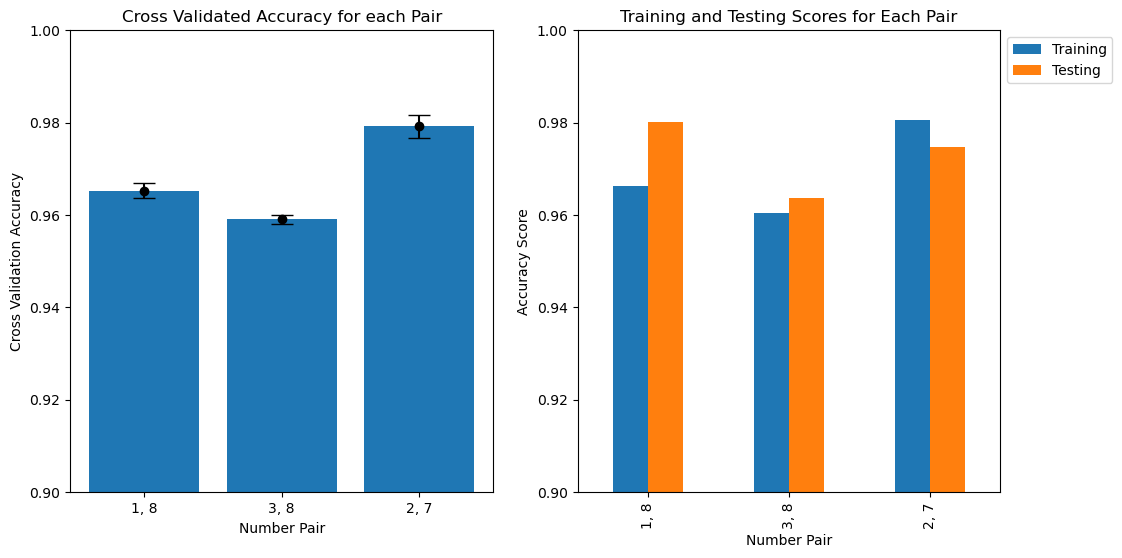

In [23]:
# Comparison of accuracy for each digit pair
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].bar(["1, 8", "3, 8", "2, 7"], sub_cross_scores)
axs[0].set_ylabel("Cross Validation Accuracy")
axs[0].set_xlabel("Number Pair")
axs[0].set_ylim([0.9, 1])
axs[0].set_title("Cross Validated Accuracy for each Pair")
axs[0].errorbar(["1, 8", "3, 8", "2, 7"], sub_cross_scores, 
                yerr = sub_cross_stds, fmt = "o", color="k", capsize=8)

scores_df = {"Pair": ["1, 8", "3, 8", "2, 7"], "Training": sub_tr_scores,
         "Testing": sub_te_scores}
scores_df = pd.DataFrame(scores_df)

scores_df.plot(x="Pair", y=["Training", "Testing"], kind="bar", ax=axs[1])
axs[1].set_ylabel("Accuracy Score")
axs[1].set_xlabel("Number Pair")
axs[1].set_ylim([0.9, 1])
axs[1].set_title("Training and Testing Scores for Each Pair")
axs[1].legend(loc='upper left', bbox_to_anchor=(1,1))

In [24]:
cv_scores = []
cv_stds = []
tr_scores = []
tr_times = []
te_scores = []

In [25]:
# Multiclass Ridge Regression

ridgemulti = RidgeClassifierCV()
xtrain_proj = pcak85.components_ @ Xtraindata
s = time.time()
ridgemulti.fit(xtrain_proj.T, ytrainlabels)
e = time.time()
tr_times.append(e-s)

In [26]:
# Score of training and testing data sets
tr_score = ridgemulti.score(xtrain_proj.T, ytrainlabels)
print("Training Score: {}".format(tr_score))
tr_scores.append(tr_score)
xtest_proj = pcak85.components_ @ Xtestdata
te_score = ridgemulti.score(xtest_proj.T, ytestlabels)
te_scores.append(te_score)
print("Testing Score: {}".format(te_score))


Training Score: 0.84515
Testing Score: 0.8567


In [27]:
# Cross validation
scores = cross_val_score(ridgemulti, xtrain_proj.T, ytrainlabels, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.8439 accuracy with a standard deviation of 0.009782268539443084


In [28]:
# KNN classification

# Data needs to be standardized
scaler = StandardScaler()
scale_x_train = scaler.fit_transform(xtrain_proj.T)
scale_x_test = scaler.transform(xtest_proj.T)

# Find the Optimal k Value
k_values = [i for i in range (1,11)]
k_scores = []

for k in k_values:
    KNNCLk = KNeighborsClassifier(n_neighbors=k)
    scorescv = cross_val_score(KNNCLk, scale_x_train, ytrainlabels,cv=5)
    k_scores.append(scorescv.mean())

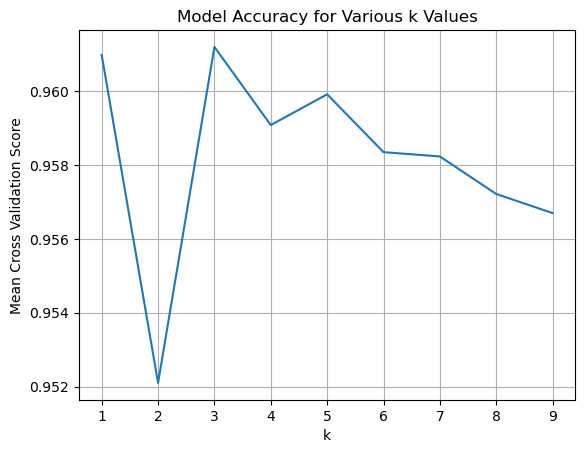

In [29]:
plt.plot(k_values[:-1], k_scores[:-1])
plt.title("Model Accuracy for Various k Values")
plt.xlabel("k")
plt.ylabel("Mean Cross Validation Score")
plt.grid(True)

In [30]:
# Use k value of 3
kopt = 3

In [31]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=kopt)
s = time.time()
knn.fit(scale_x_train, ytrainlabels)
e = time.time()
tr_times.append(e-s)

In [32]:
# Score on training and testing data sets
tr_score = knn.score(scale_x_train, ytrainlabels)
tr_scores.append(tr_score)
print("Training Score: {}".format(tr_score))
te_score = knn.score(scale_x_test, ytestlabels)
te_scores.append(te_score)
print("Testing Score: {}".format(te_score))


Training Score: 0.9826333333333334
Testing Score: 0.9619


In [33]:
# Cross validation
scores = cross_val_score(knn, scale_x_train, ytrainlabels, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.9612 accuracy with a standard deviation of 0.001602602050832777


In [1]:
# Train LDA classifier
lda = LinearDiscriminantAnalysis()
s = time.time()
lda.fit(xtrain_proj.T, ytrainlabels)
e = time.time()
tr_times.append(e-s)

NameError: name 'LinearDiscriminantAnalysis' is not defined

In [35]:
# Score of training and testing data sets
tr_score = lda.score(xtrain_proj.T, ytrainlabels)
tr_scores.append(tr_score)
print("Training Score: {}".format(tr_score))
te_score = lda.score(xtest_proj.T, ytestlabels)
te_scores.append(te_score)
print("Testing Score: {}".format(te_score))

# Cross validation
scores = cross_val_score(lda, xtrain_proj.T, ytrainlabels, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

Training Score: 0.8668333333333333
Testing Score: 0.8761
0.8653500000000001 accuracy with a standard deviation of 0.008205756786820112


In [36]:
# Train SVM Classifier
svm = SVC()
s = time.time()
svm.fit(xtrain_proj.T, ytrainlabels)
e = time.time()
tr_times.append(e-s)

In [37]:
# Score on training and testing data sets
tr_score = svm.score(xtrain_proj.T, ytrainlabels)
tr_scores.append(tr_score)
print("Training Score: {}".format(tr_score))
te_score = svm.score(xtest_proj.T, ytestlabels)
te_scores.append(te_score)
print("Testing Score: {}".format(te_score))

# Cross validation
scores = cross_val_score(svm, xtrain_proj.T, ytrainlabels, cv=5)
cv_scores.append(scores.mean())
cv_stds.append(scores.std())
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

Training Score: 0.9855
Testing Score: 0.9788
0.97615 accuracy with a standard deviation of 0.0020299151596940243


[0.8439, 0.9612, 0.8653500000000001, 0.97615]


Text(0.5, 1.0, 'Training and Testing Scores for Each Model')

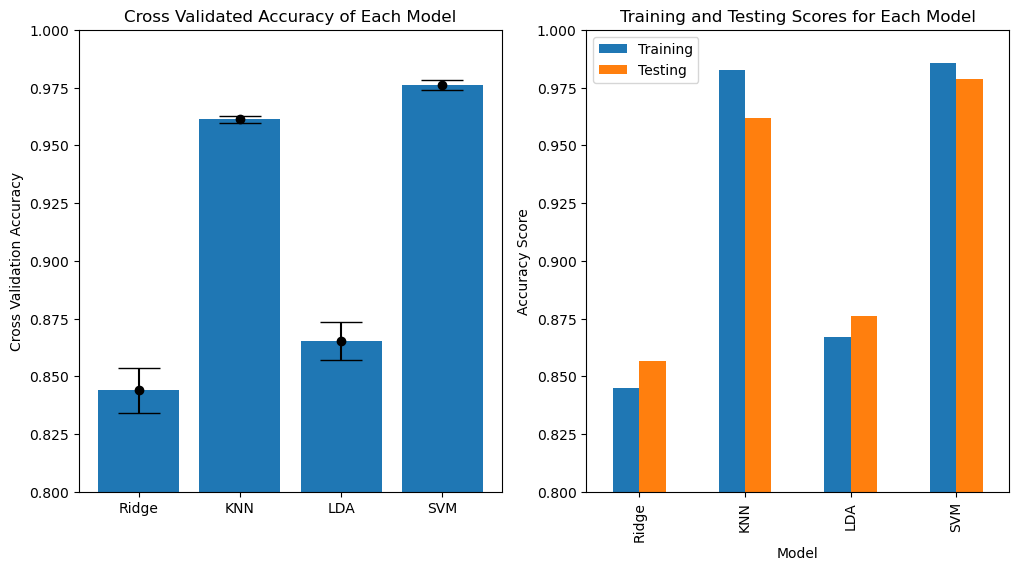

In [38]:
# Comparison of accuracy for each model
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
print(cv_scores)
axs[0].bar(["Ridge", "KNN", "LDA", "SVM"], cv_scores)
axs[0].set_ylabel("Cross Validation Accuracy")
axs[0].set_title("Cross Validated Accuracy of Each Model")
axs[0].set_ylim([0.8, 1])
axs[0].errorbar(["Ridge", "KNN", "LDA", "SVM"], cv_scores, yerr=cv_stds,
               fmt = "o", color="k", capsize=15)

scores_df = {"Model": ["Ridge", "KNN", "LDA", "SVM"], "Training": tr_scores,
         "Testing": te_scores}
scores_df = pd.DataFrame(scores_df)

scores_df.plot(x="Model", y=["Training", "Testing"], kind="bar", ax=axs[1])
axs[1].set_ylabel("Accuracy Score")
axs[1].set_ylim([0.8, 1])
axs[1].set_title("Training and Testing Scores for Each Model")

[0.3012058734893799, 0.022673845291137695, 0.39814043045043945, 49.674164056777954]


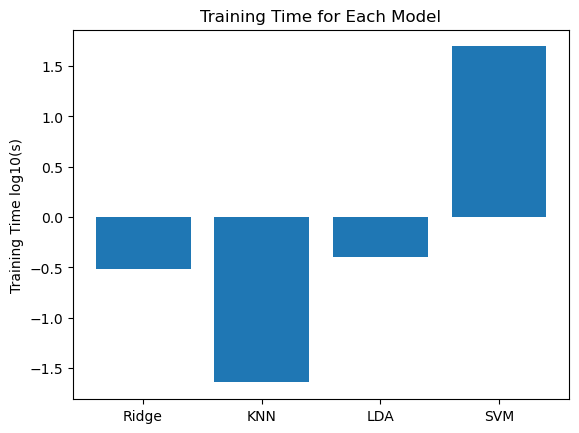

In [39]:
# Comparison of training times for each model
plt.bar(["Ridge", "KNN", "LDA", "SVM"], [np.log10(t) for t in tr_times])
plt.ylabel("Training Time log10(s)")
plt.title("Training Time for Each Model")
print(tr_times)